In [ ]:
import glob
import os
import pickle
import shutil
import distutils.dir_util

import pandas
import numpy as np
from astropy.cosmology import Planck15
from nbodykit.lab import *
import numba
%pylab inline

SIM_Z = (1 / 0.288498) - 1
SIM_MPC_LEN = 250
LOS_VEC = np.array([0, 0, 1.0])

# RSDing 1% Particle Subsample

## Loading particle subsample

In [ ]:
PARTICLE_DATA_FOLDER = '/global/homes/b/bzh/projectdir/bzh/BolshoiP/z2.5/particle-sample'

PARTICLE_BIN_DTYPE = np.dtype([('id', 'i8'),('x', 'f4'),('y', 'f4'),('z', 'f4'),('vx', 'f4'),('vy', 'f4'),('vz', 'f4')])

In [ ]:
def trim_buffers(subvol_cat):
    BUFFER_MPC = 5
    round_4th = lambda x: round(x * 4) / 4.0
    xl, xu = round_4th(subvol_cat['x'].min()), round_4th(subvol_cat['x'].max())
    yl, yu = round_4th(subvol_cat['y'].min()), round_4th(subvol_cat['y'].max())
    zl, zu = round_4th(subvol_cat['z'].min()), round_4th(subvol_cat['z'].max())
    
    xl += BUFFER_MPC
    yl += BUFFER_MPC
    zl += BUFFER_MPC
    
    xu -= BUFFER_MPC
    yu -= BUFFER_MPC
    zu -= BUFFER_MPC
    
    mask = np.logical_or.reduce([subvol_cat['x'] < xl, subvol_cat['x'] > xu,
                                subvol_cat['y'] < yl, subvol_cat['y'] > yu,
                                subvol_cat['z'] < zl, subvol_cat['z'] > zu])
    
    return subvol_cat[~mask]

In [ ]:
pickle_particles = False

if pickle_particles:
    particles = np.concatenate([trim_buffers(np.fromfile(f, dtype=PARTICLE_BIN_DTYPE)) for f in glob.glob(os.path.join(PARTICLE_DATA_FOLDER, 'sample_*.bin'))])
    _, unique_id_ind = np.unique(particles['id'], return_index=True)
    mask = np.full_like(particles, False, dtype=bool)
    mask[unique_id_ind] = True
    dup_particles = particles[~mask]
    particles = particles[mask]
    with open(os.path.join(PARTICLE_DATA_FOLDER, 'parti.pickle'), 'wb') as f:
        pickle.dump(particles, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(os.path.join(PARTICLE_DATA_FOLDER, 'parti.pickle'), 'rb') as f:
        particles = pickle.load(f)

In [ ]:
if pickle_particles:
    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    ax[0].hist(dup_particles['x'], bins=125);
    ax[0].set_xlabel('x')
    ax[1].hist(dup_particles['y'], bins=125);
    ax[1].set_xlabel('y')
    ax[2].hist(dup_particles['z'], bins=125);
    ax[2].set_xlabel('z')

In [ ]:
print(len(np.unique(particles['id'])))
print(len(particles['id']))

In [ ]:
print(particles[:5])
print(particles['id'].shape)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

ax[0].hist(particles['x'], bins=125);
ax[0].set_xlabel('x')
ax[1].hist(particles['y'], bins=125);
ax[1].set_xlabel('y')
ax[2].hist(particles['z'], bins=125);
ax[2].set_xlabel('z')

In [ ]:
particle_cat = ArrayCatalog({'Position': np.transpose([particles['x'], particles['y'], particles['z']]), 'Velocity': np.transpose([particles['vx'], particles['vy'], particles['vz']])},
                           BoxSize=SIM_MPC_LEN)

## Performing RSD

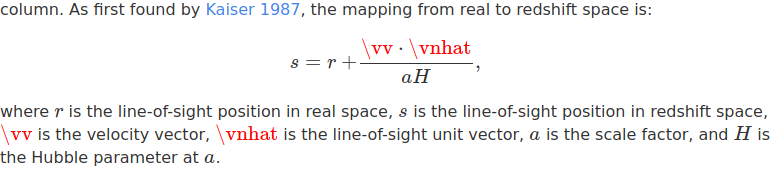

In [ ]:
@numba.njit
def vector_proj(x_arr, y):
    proj_x_arr = np.zeros_like(x_arr)
    # Projects x onto y.
    for i, x in enumerate(x_arr):
        proj_x_arr[i] = y * np.dot(x, y) / np.dot(y, y)
    return proj_x_arr

In [ ]:
rsd_factor = (1 + SIM_Z) / Planck15.H(SIM_Z).value

pos, vel = particle_cat.compute(particle_cat['Position'], particle_cat['Velocity'])
pos, vel = pos.astype(np.float64), vel.astype(np.float64)
rsd_offset = rsd_factor * vector_proj(vel, LOS_VEC)
rsd_pos = pos + rsd_offset
particle_cat['Position_RSD'] = rsd_pos
particle_cat['RSDOffset'] = rsd_offset

In [ ]:
print(rsd_offset[0] @ LOS_VEC)
print(np.linalg.norm(rsd_offset[0]))

In [ ]:
# Sanity-check how big the RSD distortions are
particle_rsd_displacements = np.sqrt((pos[:,0] - rsd_pos[:,0])**2 +
                            (pos[:,1] - rsd_pos[:,1])**2 +
                            (pos[:,2] - rsd_pos[:,2])**2)
plt.hist(particle_rsd_displacements, bins=30);

## Painting RSDed Catalog to Density Field

In [ ]:
RSD_DENSITY_PIX = 298

In [ ]:
particle_rsd_mesh = particle_cat.to_mesh(Nmesh=RSD_DENSITY_PIX, position='Position_RSD')

rsd_overdensity = particle_rsd_mesh.paint(mode='real')
print(np.mean(rsd_overdensity))

mean_binned_dens = np.mean(np.fromfile('/global/homes/b/bzh/projectdir/bzh/BolshoiP/z2.5/BolshoiP_dens_cic_n1024_0094.bin', '<f4').astype(np.float64))
rsd_density = rsd_overdensity * mean_binned_dens

In [ ]:
dens = np.fromfile('/global/homes/b/bzh/projectdir/bzh/BolshoiP/z2.5/BolshoiP_dens_cic_n1024_0094.bin', '<f4').astype(np.float64)
dens = np.reshape(dens, (1024,1024,1024), order='F')

fig, ax = plt.subplots(1, 2, figsize=(26, 13))
ax[0].imshow(rsd_density[:, :, RSD_DENSITY_PIX // 2], norm=mpl.colors.SymLogNorm(linthresh=1e0))
ax[1].imshow(dens[:, :, 512], norm=mpl.colors.SymLogNorm(linthresh=1e0))

# Save outputs

In [ ]:
np.save(os.path.join(f'/global/homes/b/bzh/projectdir/bzh/BolshoiP/z2.5/BolshoiP_rsd_cic_n{RSD_DENSITY_PIX}_0094.npy'), rsd_density[:, :, :])